In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os
import time
import copy

In [3]:
clf = models.vgg16_bn(pretrained=True)

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [8]:
data_dir = os.path.join(os.environ['HOME'], 'hse/data/hotdogs_dataset')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['hotdog', 'not_hotdog']


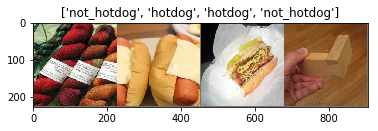

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# ResNet18

## Optimizer - SGD

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [28]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5893 Acc: 0.7787
val Loss: 0.2484 Acc: 0.9157

Epoch 1/24
----------
train Loss: 0.5448 Acc: 0.8126
val Loss: 0.2290 Acc: 0.9277

Epoch 2/24
----------
train Loss: 0.4436 Acc: 0.8259
val Loss: 0.2034 Acc: 0.9398

Epoch 3/24
----------
train Loss: 0.4691 Acc: 0.8286
val Loss: 0.3272 Acc: 0.8735

Epoch 4/24
----------
train Loss: 0.4276 Acc: 0.8425
val Loss: 0.1605 Acc: 0.9277

Epoch 5/24
----------
train Loss: 0.3501 Acc: 0.8658
val Loss: 0.2005 Acc: 0.9217

Epoch 6/24
----------
train Loss: 0.4512 Acc: 0.8346
val Loss: 0.4141 Acc: 0.8193

Epoch 7/24
----------
train Loss: 0.3326 Acc: 0.8804
val Loss: 0.2298 Acc: 0.9157

Epoch 8/24
----------
train Loss: 0.3079 Acc: 0.8904
val Loss: 0.2060 Acc: 0.9337

Epoch 9/24
----------
train Loss: 0.2469 Acc: 0.9090
val Loss: 0.2057 Acc: 0.9337

Epoch 10/24
----------
train Loss: 0.2618 Acc: 0.8957
val Loss: 0.1865 Acc: 0.9518

Epoch 11/24
----------
train Loss: 0.2717 Acc: 0.8930
val Loss: 0.1764 Acc: 0.9398

Ep

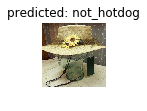

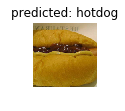

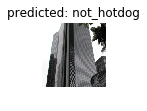

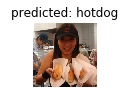

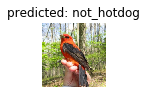

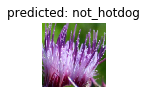

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe58ca13550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File 

In [30]:
visualize_model(model_ft)

In [31]:
torch.save(model_ft.state_dict(), 'local_resnet18_trained.pth')

## Optimizer - Adam

In [15]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6667 Acc: 0.6917
val Loss: 0.4765 Acc: 0.7831

Epoch 1/24
----------
train Loss: 0.5905 Acc: 0.7003
val Loss: 0.4614 Acc: 0.8012

Epoch 2/24
----------
train Loss: 0.5263 Acc: 0.7555
val Loss: 0.4083 Acc: 0.8434

Epoch 3/24
----------
train Loss: 0.5032 Acc: 0.7694
val Loss: 0.4145 Acc: 0.8373

Epoch 4/24
----------
train Loss: 0.5166 Acc: 0.7648
val Loss: 0.4684 Acc: 0.7410

Epoch 5/24
----------
train Loss: 0.4930 Acc: 0.7761
val Loss: 0.5216 Acc: 0.7952

Epoch 6/24
----------
train Loss: 0.4863 Acc: 0.7867
val Loss: 0.3795 Acc: 0.8494

Epoch 7/24
----------
train Loss: 0.4781 Acc: 0.7774
val Loss: 0.5873 Acc: 0.7349

Epoch 8/24
----------
train Loss: 0.4561 Acc: 0.7934
val Loss: 0.4971 Acc: 0.8012

Epoch 9/24
----------
train Loss: 0.4788 Acc: 0.7714
val Loss: 0.3220 Acc: 0.8614

Epoch 10/24
----------
train Loss: 0.4366 Acc: 0.8133
val Loss: 0.3714 Acc: 0.8434

Epoch 11/24
----------
train Loss: 0.4498 Acc: 0.8086
val Loss: 0.5558 Acc: 0.7048

Ep

# VGG16

In [22]:
model_ft = models.vgg16_bn(pretrained=True)

#### Fix weights

In [23]:
for param in model_ft.parameters():
    param.requires_grad = False

In [26]:
in_features = model_ft.classifier[6].in_features

In [28]:
model_ft.classifier[6] = nn.Linear(in_features, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3181 Acc: 0.8738
val Loss: 0.1467 Acc: 0.9578

Epoch 1/24
----------
train Loss: 0.2500 Acc: 0.9017
val Loss: 0.1413 Acc: 0.9458

Epoch 2/24
----------
train Loss: 0.3291 Acc: 0.8744
val Loss: 0.3792 Acc: 0.9337

Epoch 3/24
----------
train Loss: 0.3280 Acc: 0.8817
val Loss: 0.3618 Acc: 0.9458

Epoch 4/24
----------
train Loss: 0.3641 Acc: 0.8751
val Loss: 0.2100 Acc: 0.9518

Epoch 5/24
----------
train Loss: 0.3247 Acc: 0.8884
val Loss: 0.1062 Acc: 0.9398

Epoch 6/24
----------
train Loss: 0.2983 Acc: 0.8884
val Loss: 0.3410 Acc: 0.9277

Epoch 7/24
----------
train Loss: 0.2888 Acc: 0.8910
val Loss: 0.2313 Acc: 0.9518

Epoch 8/24
----------
